# Testing deconvolution with MC data

Tests deconvolution with MC data

In [147]:
import matplotlib
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt
from IPython.display import Image
from IPython.core.display import HTML 
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
import system_of_units as units
import tables
import mplFunctions as mpl
import wfmFunctions as wfm

In [3]:
import FEE as FE

In [4]:
import time

In [57]:
import pandas as pd

## Revised on:

In [5]:
print(time.strftime("%d/%m/%Y"))

07/11/2016


In [6]:
print(time.strftime("%H:%M:%S"))

21:20:14


###  Code exercized

In [7]:
!pep8 ../../Sierpe/FEE.py

In [8]:
!pyflakes ../../Sierpe/FEE.py

### Monte Carlo data

1. Running on electrons of fixed energy (40, 1250, 2500 keV)  in the center of chamber.
2. Nominal yield factor in current NEW conditions (7 bar, 7 kV in gate) is 574 photons/e
3. Monte Carlo yield factor 690 photons/e
4. Running of Kripton, Na, Tl, with yield factor 574 photons/e

In [11]:
yield_factor = 574./690.
print('Yield factor (MC to NEW running conditions, November, 2016 = {})'.format(yield_factor))

Yield factor (MC to NEW running conditions, November, 2016 = 0.831884057971)


#### List the files

In [12]:
ls /Users/jjgomezcadenas/Documents/Development/NEXT/icdata

IC_Kr_500evt.h5
dst_NEXT_HEAD_Kr_ACTIVE_0_0_7bar_MCRD_10000.root.h5*
dst_NEXT_HEAD_Na_INTERNALPORTANODE_0_0_7bar_MCRD_10000.root.h5*
dst_NEXT_HEAD_Tl_INTERNALPORTANODE_0_0_7bar_MCRD_10000.root.h5*
dst_NEXT_v0_08_04_Kr_ACTIVE_0_0_5bar_MCRD_10000.root.h5
dst_NEXT_v0_08_04_Na_ACTIVE_0_0_5bar_MCRD_10000.root.h5
dst_NEXT_v0_08_04_Tl_SOURCE_PORT_ANODE_0_0_5bar_MCRD_10000.root.h5
electrons.1250.0keV.z250mm.next_10.root.h5
electrons.1250.0keV.z250mm.next_100.root.h5
electrons.1250.0keV.z250mm.next_1000.root.h5
electrons.2500.0keV.z250mm.next_10.root.h5
electrons.2500.0keV.z250mm.next_100.root.h5
electrons.2500.0keV.z250mm.next_1000.root.h5
electrons.2500.0keV.z250mm.next_10000.root.h5
electrons.40.0keV.z250mm.next_10.root.h5
electrons.40.0keV.z250mm.next_100.root.h5
electrons.40.0keV.z250mm.next_1000.root.h5
electrons.40.0keV.z250mm.next_10000.root.h5
run_2609_kr.root.h5
run_2644.gdc1next.000.next1el_2644.root.h5
run_2644.gdc1next.001.next1el_2644.root.h5
run_2644.gdc1next.003.next1el_2644.roo

#### Open and inspect files

In [13]:
kr7bar = tables.open_file('/Users/jjgomezcadenas/Documents/Development/NEXT/icdata/dst_NEXT_HEAD_Kr_ACTIVE_0_0_7bar_MCRD_10000.root.h5','r+')

In [14]:
na7bar = tables.open_file('/Users/jjgomezcadenas/Documents/Development/NEXT/icdata/dst_NEXT_v0_08_04_Na_ACTIVE_0_0_5bar_MCRD_10000.root.h5','r+')

In [15]:
Tl7bar = tables.open_file('/Users/jjgomezcadenas/Documents/Development/NEXT/icdata/dst_NEXT_HEAD_Tl_INTERNALPORTANODE_0_0_7bar_MCRD_10000.root.h5','r+')

In [16]:
e2500 = tables.open_file('/Users/jjgomezcadenas/Documents/Development/NEXT/icdata/electrons.2500.0keV.z250mm.next_1000.root.h5','r+')

In [17]:
e1250 = tables.open_file('/Users/jjgomezcadenas/Documents/Development/NEXT/icdata/electrons.1250.0keV.z250mm.next_1000.root.h5','r+')

In [18]:
e40 = tables.open_file('/Users/jjgomezcadenas/Documents/Development/NEXT/icdata/electrons.40.0keV.z250mm.next_1000.root.h5','r+')

In [19]:
kr7bar

File(filename=/Users/jjgomezcadenas/Documents/Development/NEXT/icdata/dst_NEXT_HEAD_Kr_ACTIVE_0_0_7bar_MCRD_10000.root.h5, title='', mode='r+', root_uep='/', filters=Filters(complevel=0, shuffle=False, fletcher32=False, least_significant_digit=None))
/ (RootGroup) ''
/pmtrd (EArray(100, 12, 1200000), zlib(4)) ''
  atom := Int16Atom(shape=(), dflt=0)
  maindim := 0
  flavor := 'numpy'
  byteorder := 'little'
  chunkshape := (1, 1, 32768)
/sipmrd (EArray(100, 1792, 1200), zlib(4)) ''
  atom := Int16Atom(shape=(), dflt=0)
  maindim := 0
  flavor := 'numpy'
  byteorder := 'little'
  chunkshape := (1, 50, 1200)
/Detector (Group) ''
/Detector/DetectorGeometry (Table(1,)) ''
  description := {
  "x_det": Float32Col(shape=(2,), dflt=0.0, pos=0),
  "y_det": Float32Col(shape=(2,), dflt=0.0, pos=1),
  "z_det": Float32Col(shape=(2,), dflt=0.0, pos=2),
  "r_det": Float32Col(shape=(), dflt=0.0, pos=3)}
  byteorder := 'little'
  chunkshape := (2340,)
/MC (Group) ''
/MC/MCTracks (Table(686,), zlib(4))

## SIMULATING THE EFFECT OF ELECTRONICS OVER MC DATA

### PROCEDURE

1. Read MCRD (bins of 1 ns).
2. Convolute with SPE response to form a signal_i (units of A)
3. Decimate the signal.
4. Simulate the effect of the filter.

In [9]:
def fee_response(pmtrd, event=0):
    """
    input: pmtrd vector
    returns: a data frame with the PMT waveforms
    """
    spe = FE.SPE()
    fee = FE.FEE(noise_FEEPMB_rms=1*FE.NOISE_I,noise_DAQ_rms=FE.NOISE_DAQ)
    NPMT = pmtrd.shape[1]
    
    RWF = []
    BLRX = []
    for pmt in range(NPMT):
        signal_i = FE.spe_pulse_from_vector(spe, pmtrd[event,pmt])  # in current units  
        signal_d = FE.daq_decimator(FE.f_mc, FE.f_sample, signal_i)
        signal_fee = FE.signal_v_fee(fee, signal_d)*FE.v_to_adc()  #in adc counts
        signal_daq = FE.noise_adc(fee, signal_fee)
        signal_blr = signal_d*FE.i_to_adc()
        
        RWF.append(FE.OFFSET - signal_daq)
        #RWF.append(signal_daq)
        BLRX.append(signal_blr)
    
    return np.array(RWF), np.array(BLRX)

In [271]:
RWF, BLRX = fee_response(e40.root.pmtrd, event=0) 

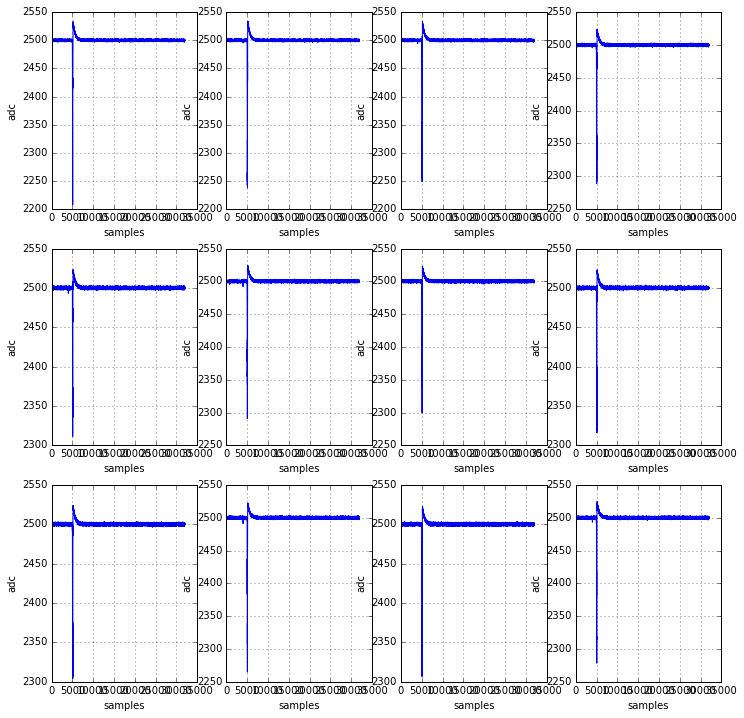

In [233]:
mpl.plot_waveforms(RWF, maxlen=0, zoom=False, window_size=800)

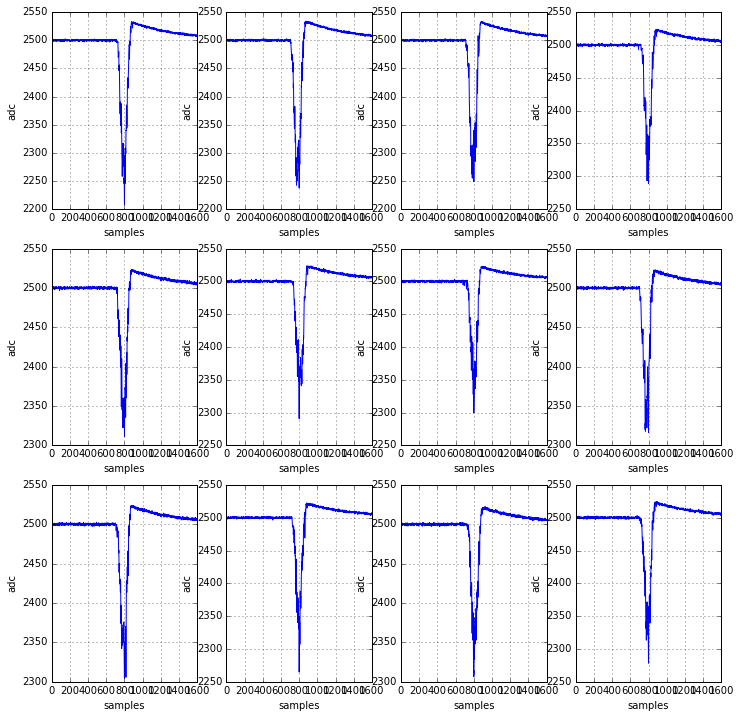

In [234]:
mpl.plot_waveforms(RWF, maxlen=0, zoom=True, window_size=800)

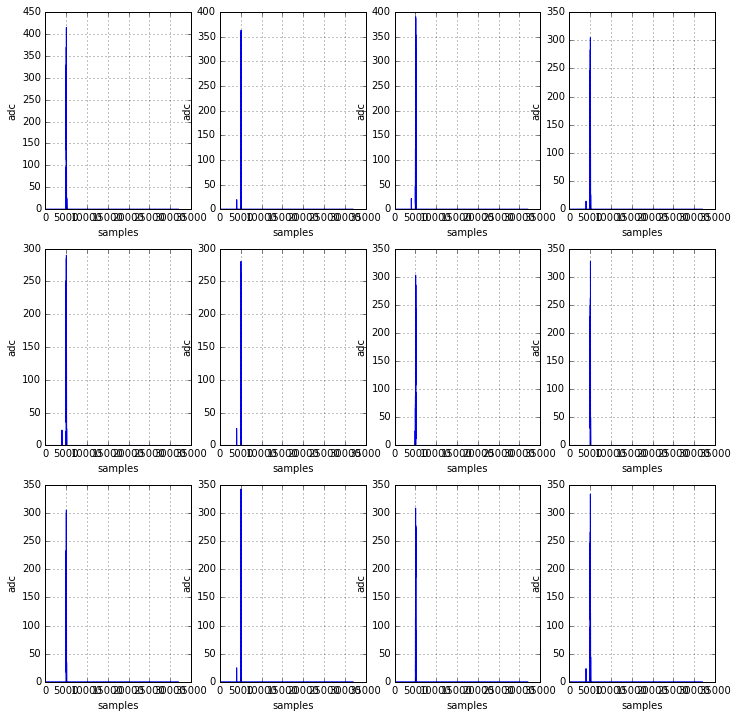

In [235]:
mpl.plot_waveforms(BLRX, maxlen=0, zoom=False, window_size=800)

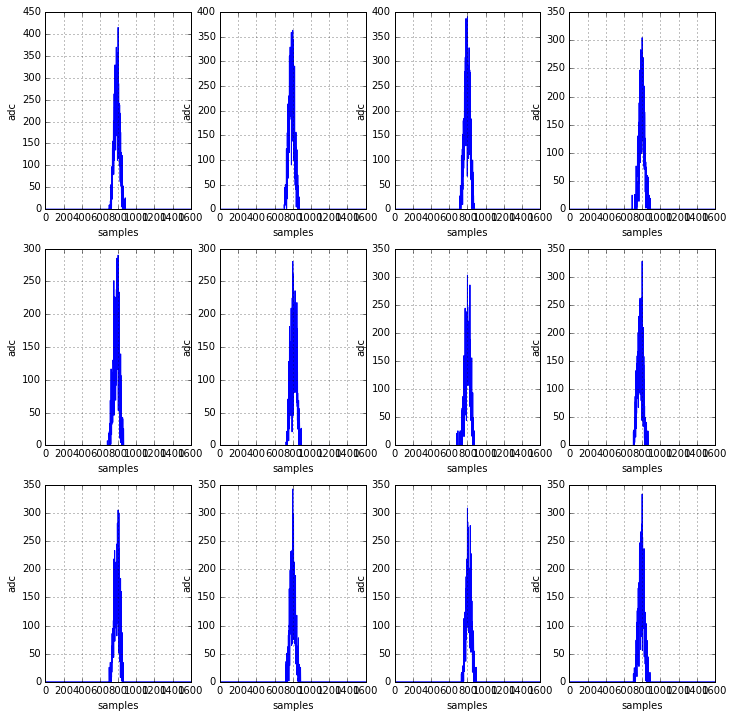

In [236]:
mpl.plot_waveforms(BLRX, maxlen=0, zoom=True, window_size=800)

## Deconvolution

In [237]:
def deconvolve_signal(signal_daq, mau_len=1000, 
                      coef_clean=2.905447E-06, coef_blr=1.632411E-03, 
                      thr1=5, thr2=1, thr3=1,
                      filter_c=True):
    """
    Deconvolve the signal. 
    1) compute the baseline and the noise rms
    2) clean the signal
    3) apply BLR
    """
    coef = coef_blr
    nm = mau_len
    len_signal_daq = len(signal_daq)
    signal_r = np.zeros(len_signal_daq, dtype=np.double)
    MAU = np.zeros(len_signal_daq, dtype=np.double)
    acum = np.zeros(len_signal_daq, dtype=np.double)
    pulse_on = np.zeros(len_signal_daq, dtype=np.int8)
    wait_over = np.zeros(len_signal_daq, dtype=np.int8)
    trigger_1 = np.zeros(len_signal_daq, dtype=np.double)
    trigger_2 = np.zeros(len_signal_daq, dtype=np.double)
    
    
    BASELINE, noise_rms = find_baseline(signal_daq, mau_len=nm)
    MAU[0:nm] = BASELINE
    
    # change sign and subtract baseline
    signal_daq =  BASELINE - signal_daq
 
    # clean function
    if (filter_c==True):
        b_cf, a_cf = signal.butter(1, coef_clean, 'high', analog=False);
        signal_daq = signal.lfilter(b_cf,a_cf,signal_daq)
 
    # BLR
    signal_r[0:nm] = signal_daq[0:nm] 
    p_on = 0
    w_over = 0 
    offset = 0
    
    # trigger_line = thr1*noise_rms
    # trigger_off = thr2*noise_rms
    # print('trigger_line = {} trigger_off = {}'.format(trigger_line, trigger_off))
    
    for k in range(nm,len_signal_daq):
        trigger_line = MAU[k-1] + thr1*noise_rms
        trigger_off = MAU[k-1] + thr2*noise_rms
        pulse_on[k] = p_on
        wait_over[k] = w_over
        trigger_1[k] = trigger_line
        trigger_2[k] = trigger_off
                                                                          
        # condition: raw signal raises above trigger line and
        # we are not in the tail
        # (w_over == 0)
        
        #if k > kmin and k < kmax:
        #    print("""k = {} pulse_on = {} wait_over ={}, signal_daq = {} signal_r = {}
        #    """.format(k, pulse_on[k-1], wait_over[k-1], signal_daq[k-1], signal_r[k-1]))
            
        if signal_daq[k] > trigger_line and w_over == 0:

            # if the pulse just started pulse_on = 0.
            # In this case compute the offset as value
            # of the MAU before pulse starts (at k-1)

            if p_on == 0: # pulse just started
                offset = MAU[k-1]
                p_on = 1

            # Pulse is on: Freeze the MAU
            MAU[k] = MAU[k-1]

            #update recovered signal, correcting by offset
            signal_r[k] = signal_daq[k] + signal_daq[k]*(coef/2.0) + coef*acum[k-1] 
            acum[k] = acum[k-1] + signal_daq[k] - offset
            
        else:  # signal_daq[k] < trigger_line or w_over == 1

            if p_on == 1: # reconstructed signal still on
                # switch the pulse off only when recovered signal
                # drops below threshold
                # slide the MAU, still frozen.
                # keep recovering signal

                MAU[k] = MAU[k-1]
                signal_r[k] = signal_daq[k] + signal_daq[k]*(coef/2.0) + coef*acum[k-1] 
                acum[k] = acum[k-1] + signal_daq[k] - offset
                
                # if the recovered signal drops before trigger line
                # rec pulse is over!
                
                if signal_r[k] < trigger_off:
                    w_over = 1  # start tail compensation
                    p_on = 0   # recovered pulse is over


            else:  # recovered signal has droped below trigger line
            # need to compensate the tail to avoid drifting due to erros in
            # baseline calculatoin

                if w_over == 1: # compensating pulse
                    # recovered signal and raw signal
                    # must be equal within a threshold
                    # otherwise keep compensating pluse

                    if abs(signal_daq[k-1] - signal_r[k-1]) > thr3*noise_rms:
                        # raw signal still not close to recovered signal
                        # keep compensating pulse
                        
                        signal_r[k] = signal_daq[k] + signal_daq[k]*(coef/2.0) +\
                                      coef*acum[k-1] 
                        acum[k] = acum[k-1] + signal_daq[k] - offset

                    else:  # raw signal ~=  recovered signal: we are done

                        w_over = 0
                        acum[k] = MAU[k-1]
                        signal_r[k] = signal_daq[k]
                        MAU[k] = np.mean(signal_daq[k-nm:k]*1.)


                else: #signal still not found

                    # update MAU and signals
                    MAU[k] = np.mean(signal_daq[k-nm:k]*1.)
                    acum[k] = MAU[k-1]
                    signal_r[k] = signal_daq[k]
    
    sm = np.amax(signal_r)
    BLR={}
    BLR['acum'] = acum
    BLR['pulse_on'] = pulse_on
    BLR['wait_over'] = wait_over
    BLR['MAU'] = MAU
    BLR['trigger_1'] = trigger_1
    BLR['trigger_2'] = trigger_2
    BLR['signal_daq'] = signal_daq
    BLR['sm'] = sm
    BLR['signal_r'] = signal_r
    BLR['signal_daq'] = signal_daq
                    

    return  signal_r, BLR

In [238]:
def deconvolve_signal_acum(signal_daq, n_baseline=500, 
                      coef_clean=2.905447E-06, coef_blr=1.632411E-03, 
                      thr_trigger=5, thr_acum=800, coeff_acum = 0.9995,
                      filter_c=True):

    """
    The accumulator approach by Master VHB

    """
    
    coef = coef_blr
    nm = n_baseline
    
    len_signal_daq = len(signal_daq)
    signal_r = np.zeros(len_signal_daq, dtype=np.double)
    acum = np.zeros(len_signal_daq, dtype=np.double)
    pulse_on = np.zeros(len_signal_daq, dtype=np.int8)
    
    baseline = np.mean(signal_daq[0:nm])
    noise_rms = np.std(signal_daq[0:nm],ddof=1)
    trigger_line =  thr_trigger*noise_rms
    
    #print ("baseline = {} noise (LSB_rms) = {}".format(baseline, noise_rms))
    #print ("trigger line = {} LSB".format(trigger_line))
    
    # change sign and subtract baseline
    signal_daq =  baseline - signal_daq
    
    # clean function
    if filter_c==True:
        b_cf, a_cf = signal.butter(1, coef_clean, 'high', analog=False);
        signal_daq = signal.lfilter(b_cf,a_cf,signal_daq)
 
    # BLR
    signal_r[0:nm] = signal_daq[0:nm] 
    p_on = 0
    
    for k in range(nm,len_signal_daq): 
        pulse_on[k] = p_on
        
        # condition: raw signal raises above trigger line 
        if (signal_daq[k] > trigger_line) or (acum[k-1] > thr_acum):
            if p_on == 0:
                p_on = 1
            # update recovered signal, correcting by offset while acum > thr_acum
            
            signal_r[k] = signal_daq[k] + signal_daq[k]*(coef/2.0) + coef*acum[k-1] 
            acum[k] = acum[k-1] + signal_daq[k] 
                   
        else:
            if p_on == 1:
                p_on = 0
                
            signal_r[k] = signal_daq[k]
            # deplete the accumulator before or after the signal to avoid runoffs
            if (acum[k-1]>0):
                acum[k]=acum[k-1]*coeff_acum
    
    BLR={}
    BLR['acum'] = acum
    BLR['pulse_on'] = pulse_on
    BLR['signal_daq'] = signal_daq
    BLR['signal_r'] = signal_r
    
    return pd.DataFrame(BLR)

In [239]:
signal_daq = RWF[0]

In [240]:
fee = FE.FEE(noise_FEEPMB_rms=1*FE.NOISE_I,noise_DAQ_rms=FE.NOISE_DAQ)
freq_zero = 1./(fee.R1*fee.C1)
freq_zerod = freq_zero/(fee.f_sample*np.pi)
coef_c = freq_zerod
coef_blr = fee.freq_LHPFd*np.pi
print('coef_c = {}'.format(coef_c))
print('coef_blr = {}'.format(coef_blr)) 

coef_c = 1.87116159952e-06
coef_blr = 0.00192400951255


In [241]:
signal_r, BLR = deconvolve_signal(signal_daq, mau_len=128, 
                                  coef_clean=freq_zerod, 
                                  coef_blr=fee.freq_LHPFd*np.pi, 
                                  thr1 = 5, thr2 = 1, thr3=0.3)

baseline = 2500.08981237 noise (LSB_rms) = 0.792913428966


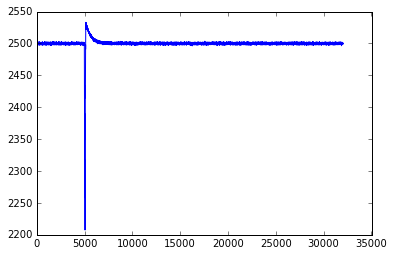

In [242]:
plt.plot(signal_daq)

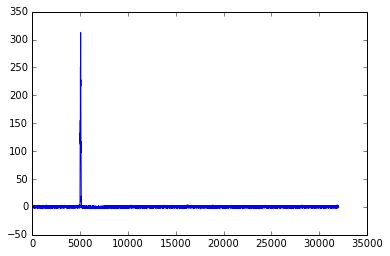

In [243]:
plt.plot(signal_r)

In [244]:
np.sum(signal_r[4960:5130]/FE.ADC_TO_PES)

988.96326349913011

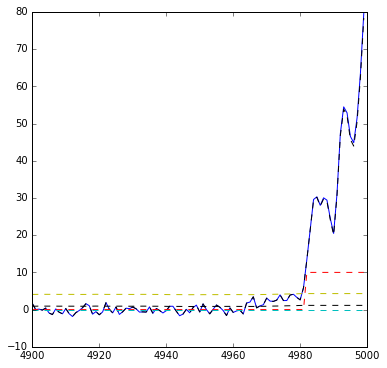

In [245]:
plt.figure(figsize=(6, 6))
xmin=4900
xmax=5000
plt.plot(range(xmin,xmax),signal_r[xmin:xmax])
plt.plot(range(xmin,xmax),BLR['signal_daq'][xmin:xmax],'k--')
plt.plot(range(xmin,xmax), BLR['trigger_1'][xmin:xmax],'y--', linewidth=1)
plt.plot(range(xmin,xmax), BLR['trigger_2'][xmin:xmax],'k--', linewidth=1)
plt.plot(range(xmin,xmax), BLR['pulse_on'][xmin:xmax]*10,'r--', linewidth=1)
plt.plot(range(xmin,xmax), BLR['wait_over'][xmin:xmax]*10,'c--', linewidth=1)

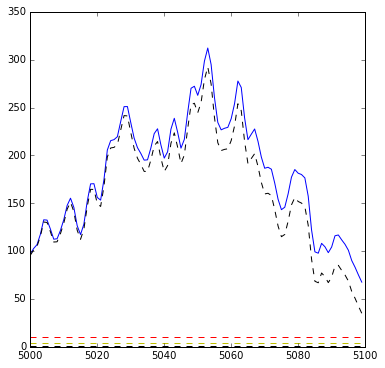

In [246]:
plt.figure(figsize=(6, 6))
xmin=5000
xmax=5100
plt.plot(range(xmin,xmax),signal_r[xmin:xmax])
plt.plot(range(xmin,xmax),BLR['signal_daq'][xmin:xmax],'k--')
plt.plot(range(xmin,xmax), BLR['trigger_1'][xmin:xmax],'y--', linewidth=1)
plt.plot(range(xmin,xmax), BLR['trigger_2'][xmin:xmax],'k--', linewidth=1)
plt.plot(range(xmin,xmax), BLR['pulse_on'][xmin:xmax]*10,'r--', linewidth=1)
plt.plot(range(xmin,xmax), BLR['wait_over'][xmin:xmax]*20,'c--', linewidth=1)

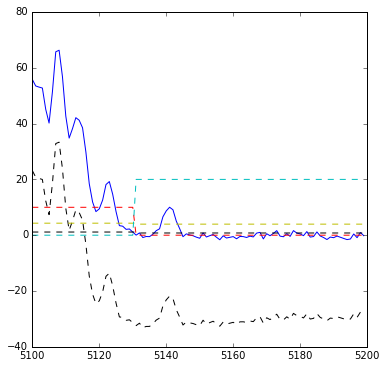

In [247]:
plt.figure(figsize=(6, 6))
xmin=5100
xmax=5200
plt.plot(range(xmin,xmax),signal_r[xmin:xmax])
plt.plot(range(xmin,xmax),BLR['signal_daq'][xmin:xmax],'k--')
plt.plot(range(xmin,xmax), BLR['trigger_1'][xmin:xmax],'y--', linewidth=1)
plt.plot(range(xmin,xmax), BLR['trigger_2'][xmin:xmax],'k--', linewidth=1)
plt.plot(range(xmin,xmax), BLR['pulse_on'][xmin:xmax]*10,'r--', linewidth=1)
plt.plot(range(xmin,xmax), BLR['wait_over'][xmin:xmax]*20,'c--', linewidth=1)

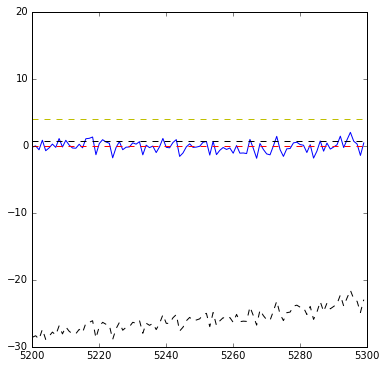

In [248]:
plt.figure(figsize=(6, 6))
xmin=5200
xmax=5300
plt.plot(range(xmin,xmax),signal_r[xmin:xmax])
plt.plot(range(xmin,xmax),BLR['signal_daq'][xmin:xmax],'k--')
plt.plot(range(xmin,xmax), BLR['trigger_1'][xmin:xmax],'y--', linewidth=1)
plt.plot(range(xmin,xmax), BLR['trigger_2'][xmin:xmax],'k--', linewidth=1)
plt.plot(range(xmin,xmax), BLR['pulse_on'][xmin:xmax]*10,'r--', linewidth=1)
plt.plot(range(xmin,xmax), BLR['wait_over'][xmin:xmax]*20,'c--', linewidth=1)

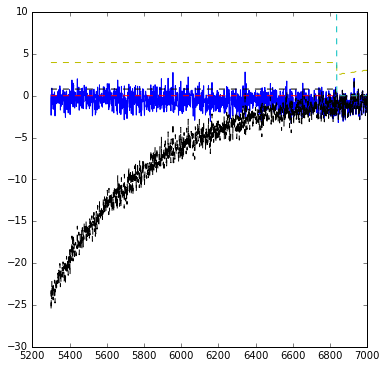

In [249]:
plt.figure(figsize=(6, 6))
xmin=5300
xmax=7000
plt.plot(range(xmin,xmax),signal_r[xmin:xmax])
plt.plot(range(xmin,xmax),BLR['signal_daq'][xmin:xmax],'k--')
plt.plot(range(xmin,xmax), BLR['trigger_1'][xmin:xmax],'y--', linewidth=1)
plt.plot(range(xmin,xmax), BLR['trigger_2'][xmin:xmax],'k--', linewidth=1)
plt.plot(range(xmin,xmax), BLR['pulse_on'][xmin:xmax]*10,'r--', linewidth=1)
plt.plot(range(xmin,xmax), BLR['wait_over'][xmin:xmax]*10,'c--', linewidth=1)

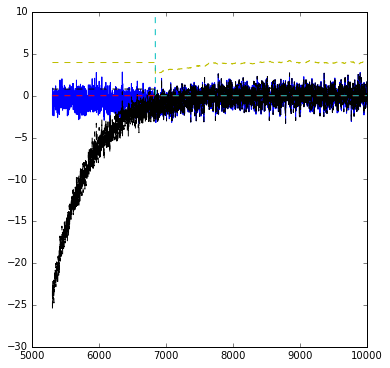

In [250]:
plt.figure(figsize=(6, 6))
xmin=5300
xmax=10000
plt.plot(range(xmin,xmax),signal_r[xmin:xmax])
plt.plot(range(xmin,xmax),BLR['signal_daq'][xmin:xmax],'k--')
plt.plot(range(xmin,xmax), BLR['trigger_1'][xmin:xmax],'y--', linewidth=1)
plt.plot(range(xmin,xmax), BLR['trigger_2'][xmin:xmax],'k--', linewidth=1)
plt.plot(range(xmin,xmax), BLR['pulse_on'][xmin:xmax]*10,'r--', linewidth=1)
plt.plot(range(xmin,xmax), BLR['wait_over'][xmin:xmax]*10,'c--', linewidth=1)

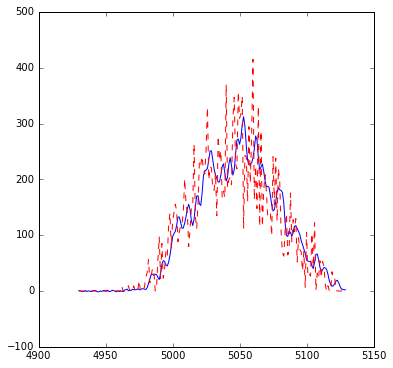

In [272]:
plt.figure(figsize=(6, 6))
xmin=4930
xmax=5130
plt.plot(range(xmin,xmax),signal_r[xmin:xmax])
plt.plot(range(xmin,xmax),BLRX[0][xmin:xmax],'r--', linewidth=1)

In [273]:
xmin=4930
xmax=5130
energy_mea=np.sum(signal_r[xmin:xmax])
energy_in=np.sum(BLRX[0][xmin:xmax])
print('Input Energy = {}'.format(energy_in))
print('Reconstructed Energy = {}'.format(energy_mea))
print('Error in Energy Computation (%) = {}'.format((energy_in-energy_mea)/energy_in*100))

Input Energy = 19825.0554209
Reconstructed Energy = 19776.6298215
Error in Energy Computation (%) = 0.244264635942


### Acumulator-based deconvolution

In [251]:
BLR = deconvolve_signal_acum(signal_daq, n_baseline=500, 
                      coef_clean=coef_c, coef_blr=coef_blr, 
                      thr_trigger=5, thr_acum=800, coeff_acum = 0.9995,
                      filter_c=True)

baseline = 2500.04941538 noise (LSB_rms) = 0.837850812998
trigger line = 4.18925406499 LSB


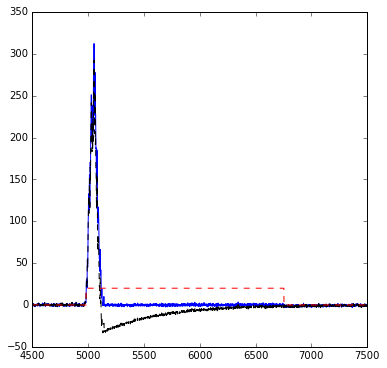

In [252]:
plt.figure(figsize=(6, 6))
xmin=4500
xmax=7500
plt.plot(range(xmin,xmax),BLR.signal_r[xmin:xmax])
plt.plot(range(xmin,xmax),BLR.signal_daq[xmin:xmax],'k--', linewidth=1)
plt.plot(range(xmin,xmax), BLR['pulse_on'][xmin:xmax]*20,'r--', linewidth=1)

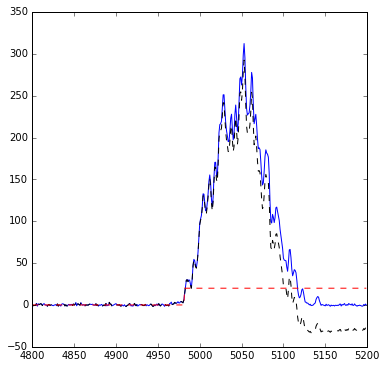

In [253]:
plt.figure(figsize=(6, 6))
xmin=4800
xmax=5200
plt.plot(range(xmin,xmax),BLR.signal_r[xmin:xmax])
plt.plot(range(xmin,xmax),BLR.signal_daq[xmin:xmax],'k--', linewidth=1)
plt.plot(range(xmin,xmax), BLR['pulse_on'][xmin:xmax]*20,'r--', linewidth=1)

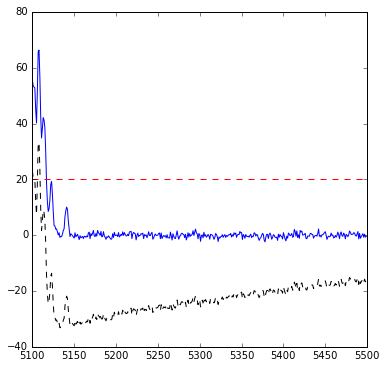

In [256]:
plt.figure(figsize=(6, 6))
xmin=5100
xmax=5500
plt.plot(range(xmin,xmax),BLR.signal_r[xmin:xmax])
plt.plot(range(xmin,xmax),BLR.signal_daq[xmin:xmax],'k--', linewidth=1)
plt.plot(range(xmin,xmax), BLR['pulse_on'][xmin:xmax]*20,'r--', linewidth=1)

In [317]:
def blr_stats(pmtrd, event_list=[0], xmin=4930, xmax=5130, pmtid=0, plot=False):
    ER = np.zeros(len(event_list), dtype=np.double)
    
    for i, event in enumerate(event_list):
        print('event = {}'.format(event))
        RWF, BLRX = fee_response(pmtrd, event=event)
        BLR = deconvolve_signal_acum(RWF[pmtid], n_baseline=500, 
                      coef_clean=coef_c, coef_blr=coef_blr, 
                      thr_trigger=5, thr_acum=800, coeff_acum = 0.9995,
                      filter_c=True)
        
        energy_mea=np.sum(BLR.signal_r[xmin:xmax])
        energy_in=np.sum(BLRX[pmtid][xmin:xmax])
        ER[i] = 100*abs(energy_mea - energy_in)/energy_in
        
        if plot == True:
            plt.figure(figsize=(6, 6))
            plt.plot(range(xmin,xmax),BLR.signal_r[xmin:xmax])
            plt.plot(range(xmin,xmax),BLRX[pmtid][xmin:xmax],'r--', linewidth=1)
            print('Input Energy = {}'.format(energy_in))
            print('Reconstructed Energy = {}'.format(energy_mea))
            print('Error in Energy Computation (%) = {}'.format(ER[i]))
    return ER
  

baseline = 2499.99689113 noise (LSB_rms) = 0.900835628289
trigger line = 4.50417814145 LSB
Input Energy = 19825.0554209
Reconstructed Energy = 19775.2507827
Error in Energy Computation (%) = 0.251220675829
baseline = 2500.06879303 noise (LSB_rms) = 0.867907136496
trigger line = 4.33953568248 LSB
Input Energy = 20863.2099178
Reconstructed Energy = 20844.4482568
Error in Energy Computation (%) = 0.0899270106847
baseline = 2499.98071281 noise (LSB_rms) = 0.86345651804
trigger line = 4.3172825902 LSB
Input Energy = 21082.5573131
Reconstructed Energy = 21046.6295746
Error in Energy Computation (%) = 0.170414518427
baseline = 2499.98977488 noise (LSB_rms) = 0.801348399169
trigger line = 4.00674199585 LSB
Input Energy = 20355.9756377
Reconstructed Energy = 20302.154956
Error in Energy Computation (%) = 0.264397456085
baseline = 2499.9599969 noise (LSB_rms) = 0.862176310109
trigger line = 4.31088155055 LSB
Input Energy = 20718.940516
Reconstructed Energy = 20710.7523697
Error in Energy Computa

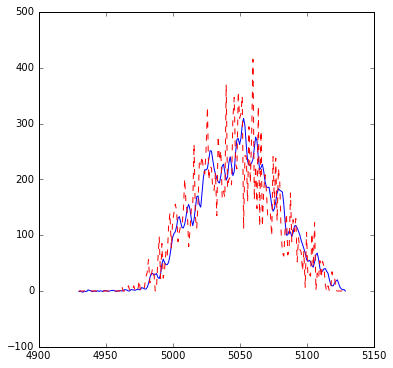

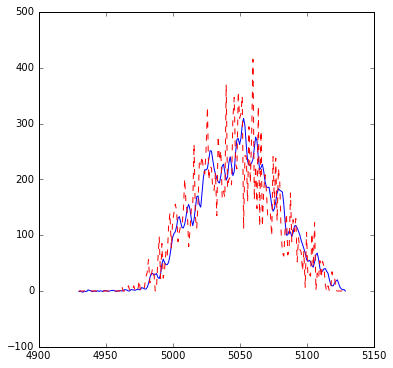

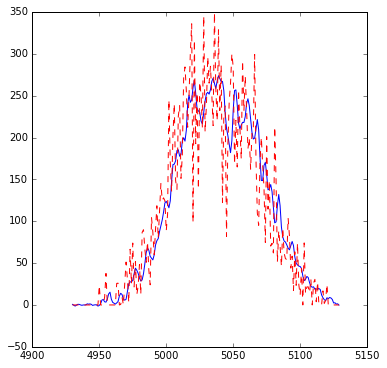

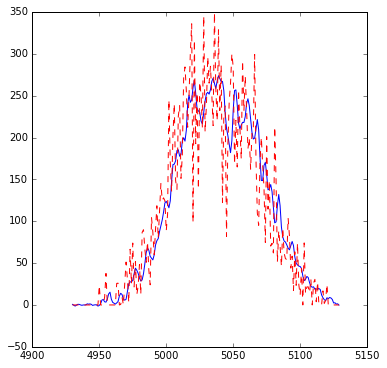

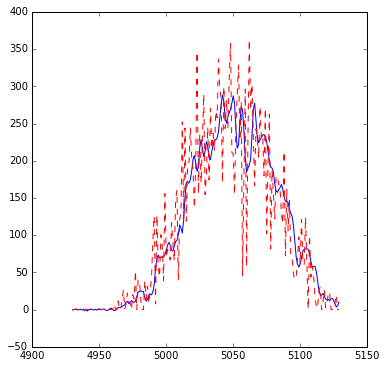

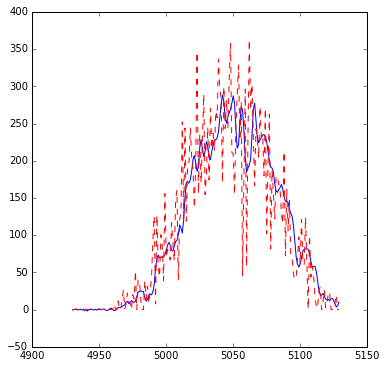

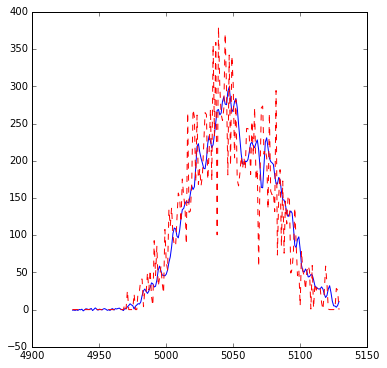

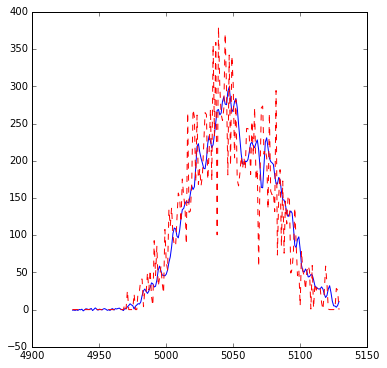

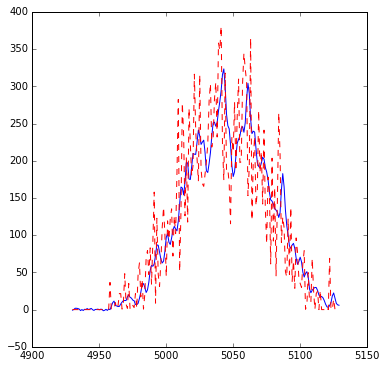

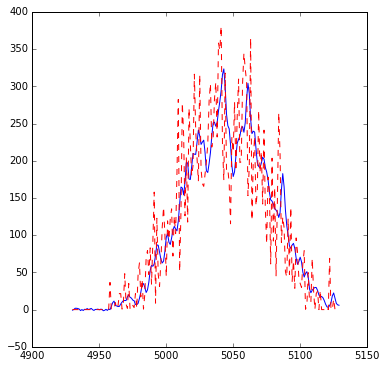

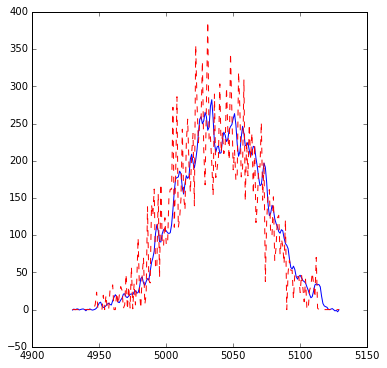

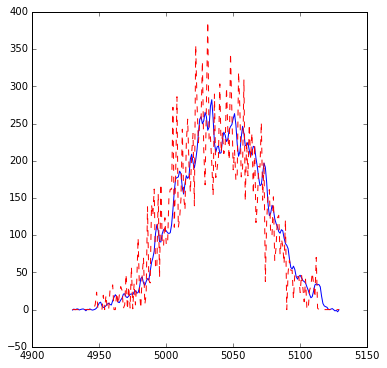

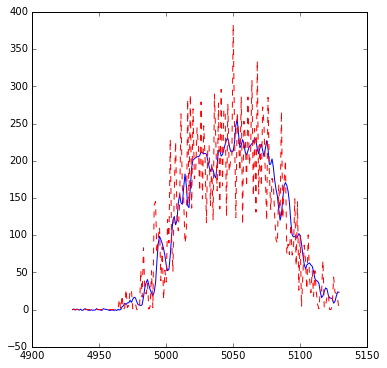

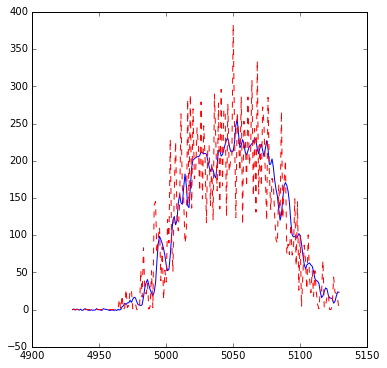

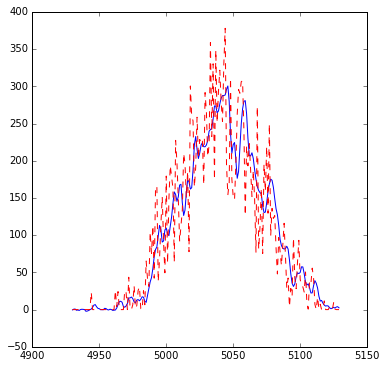

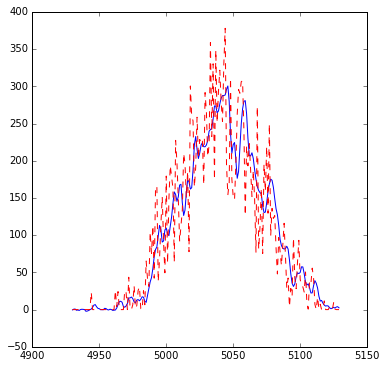

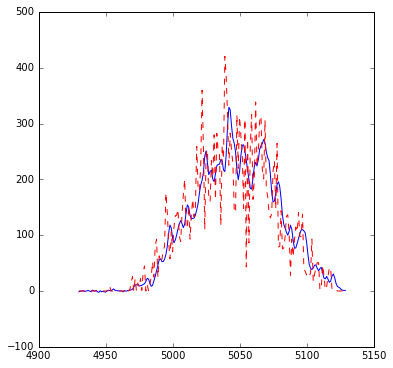

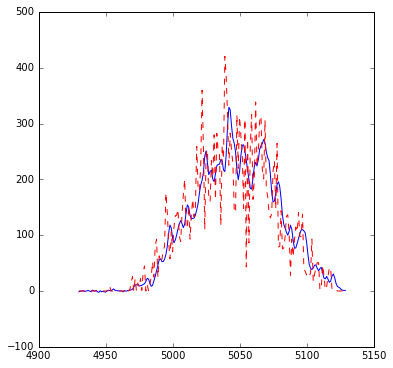

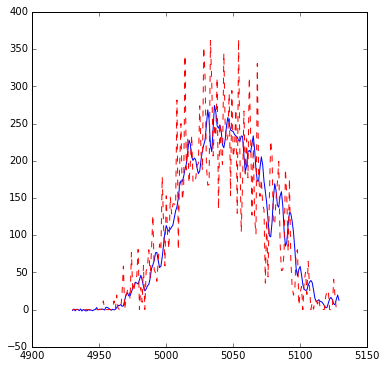

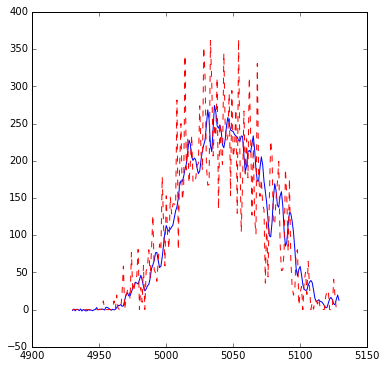

In [313]:
ER = blr_stats(e40.root.pmtrd, event_list=range(10), xmin=4930, xmax=5130, pmtid=0, plot=True)

In [314]:
ER = blr_stats(e40.root.pmtrd, event_list=range(100), xmin=4930, xmax=5130, pmtid=0, plot=False)

baseline = 2500.06218083 noise (LSB_rms) = 0.946948924817
trigger line = 4.73474462408 LSB
baseline = 2500.02482514 noise (LSB_rms) = 0.868357459611
trigger line = 4.34178729806 LSB
baseline = 2499.98818994 noise (LSB_rms) = 0.884131949476
trigger line = 4.42065974738 LSB
baseline = 2500.03891158 noise (LSB_rms) = 0.901925524086
trigger line = 4.50962762043 LSB
baseline = 2499.96432586 noise (LSB_rms) = 0.894377955151
trigger line = 4.47188977575 LSB
baseline = 2499.96451723 noise (LSB_rms) = 0.895698850804
trigger line = 4.47849425402 LSB
baseline = 2500.01125319 noise (LSB_rms) = 0.845330020097
trigger line = 4.22665010048 LSB
baseline = 2499.95407704 noise (LSB_rms) = 0.884491849267
trigger line = 4.42245924634 LSB
baseline = 2499.98628665 noise (LSB_rms) = 0.925123978056
trigger line = 4.62561989028 LSB
baseline = 2499.92328154 noise (LSB_rms) = 0.843993005574
trigger line = 4.21996502787 LSB
baseline = 2500.0006536 noise (LSB_rms) = 0.853819799337
trigger line = 4.26909899669 LSB


(array([ 32.,  15.,  22.,  14.,   8.,   3.,   4.,   0.,   0.,   2.]),
 array([  3.49243737e-04,   4.29757364e-02,   8.56022291e-02,
          1.28228722e-01,   1.70855214e-01,   2.13481707e-01,
          2.56108200e-01,   2.98734692e-01,   3.41361185e-01,
          3.83987678e-01,   4.26614170e-01]),
 <a list of 10 Patch objects>)

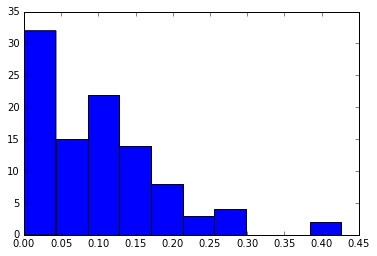

In [315]:
plt.hist(ER)

event = 0
baseline = 2499.96343657 noise (LSB_rms) = 0.854299853414
trigger line = 4.27149926707 LSB
Input Energy = 20735.9714787
Reconstructed Energy = 20709.0485842
Error in Energy Computation (%) = 0.129836668552


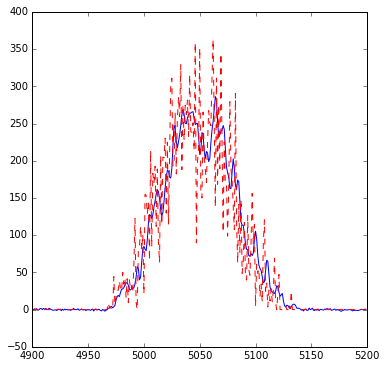

In [318]:
ER = blr_stats(e40.root.pmtrd, event_list=range(1), xmin=4900, xmax=5200, pmtid=1, plot=True)

In [319]:
ER = blr_stats(e40.root.pmtrd, event_list=range(100), xmin=4950, xmax=5150, pmtid=1, plot=False)

event = 0
baseline = 2500.0011182 noise (LSB_rms) = 0.851431386657
trigger line = 4.25715693329 LSB
event = 1
baseline = 2500.06186853 noise (LSB_rms) = 0.826899921678
trigger line = 4.13449960839 LSB
event = 2
baseline = 2500.03151759 noise (LSB_rms) = 0.911168086751
trigger line = 4.55584043376 LSB
event = 3
baseline = 2499.99516582 noise (LSB_rms) = 0.853909021992
trigger line = 4.26954510996 LSB
event = 4
baseline = 2499.97079055 noise (LSB_rms) = 0.873863037007
trigger line = 4.36931518504 LSB
event = 5
baseline = 2499.94369951 noise (LSB_rms) = 0.87476364144
trigger line = 4.3738182072 LSB
event = 6
baseline = 2500.02438939 noise (LSB_rms) = 0.876263121368
trigger line = 4.38131560684 LSB
event = 7
baseline = 2500.05750087 noise (LSB_rms) = 0.882656965932
trigger line = 4.41328482966 LSB
event = 8
baseline = 2500.01011583 noise (LSB_rms) = 0.877339663711
trigger line = 4.38669831855 LSB
event = 9
baseline = 2499.97708283 noise (LSB_rms) = 0.852057834379
trigger line = 4.260289171

(array([ 20.,  21.,  15.,  13.,   9.,   8.,   5.,   2.,   4.,   3.]),
 array([ 0.00350217,  0.02778118,  0.05206018,  0.07633919,  0.1006182 ,
         0.1248972 ,  0.14917621,  0.17345521,  0.19773422,  0.22201323,
         0.24629223]),
 <a list of 10 Patch objects>)

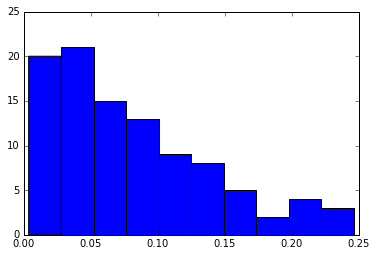

In [320]:
plt.hist(ER)

In [321]:
ER = blr_stats(e40.root.pmtrd, event_list=range(900), xmin=4950, xmax=5150, pmtid=11, plot=False)

event = 0
baseline = 2500.00489953 noise (LSB_rms) = 0.886927675419
trigger line = 4.4346383771 LSB
event = 1
baseline = 2499.99512196 noise (LSB_rms) = 0.842761096449
trigger line = 4.21380548225 LSB
event = 2
baseline = 2499.99000091 noise (LSB_rms) = 0.841776866379
trigger line = 4.2088843319 LSB
event = 3
baseline = 2499.98740241 noise (LSB_rms) = 0.945257799299
trigger line = 4.72628899649 LSB
event = 4
baseline = 2500.03464195 noise (LSB_rms) = 0.862227929915
trigger line = 4.31113964957 LSB
event = 5
baseline = 2500.00296968 noise (LSB_rms) = 0.905395359806
trigger line = 4.52697679903 LSB
event = 6
baseline = 2500.06263548 noise (LSB_rms) = 0.8472930828
trigger line = 4.236465414 LSB
event = 7
baseline = 2500.0026686 noise (LSB_rms) = 0.865773060649
trigger line = 4.32886530325 LSB
event = 8
baseline = 2500.07467383 noise (LSB_rms) = 0.875617263991
trigger line = 4.37808631996 LSB
event = 9
baseline = 2500.03883881 noise (LSB_rms) = 0.860083876932
trigger line = 4.30041938466 L

(array([ 273.,  245.,  169.,  101.,   63.,   34.,   10.,    3.,    1.,    1.]),
 array([  8.19921389e-05,   6.19961928e-02,   1.23910394e-01,
          1.85824594e-01,   2.47738795e-01,   3.09652996e-01,
          3.71567196e-01,   4.33481397e-01,   4.95395598e-01,
          5.57309799e-01,   6.19223999e-01]),
 <a list of 10 Patch objects>)

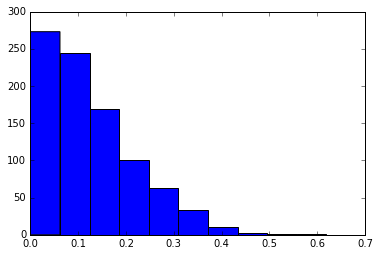

In [322]:
plt.hist(ER)

In [323]:
RWF, BLRX = fee_response(e1250.root.pmtrd, event=0) 

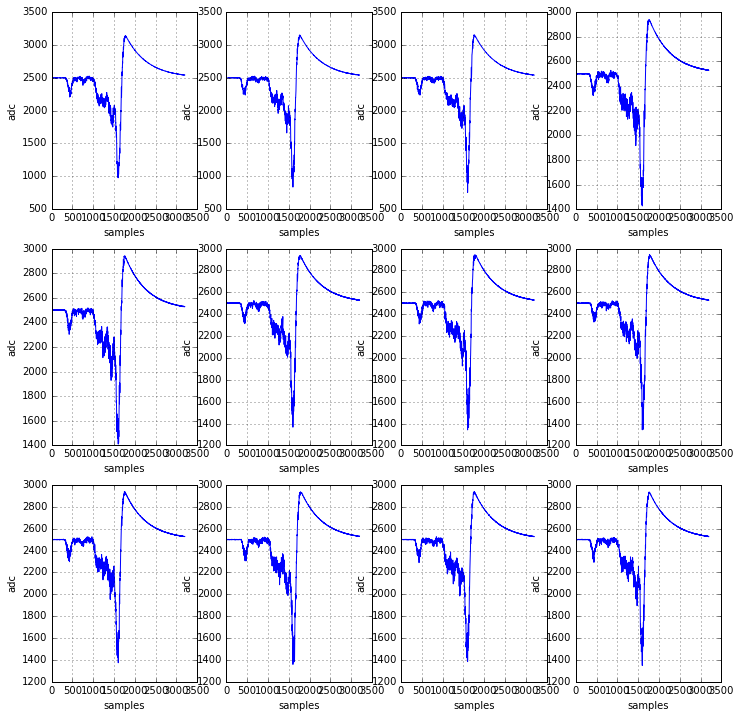

In [324]:
mpl.plot_waveforms(RWF, maxlen=0, zoom=True, window_size=1600)

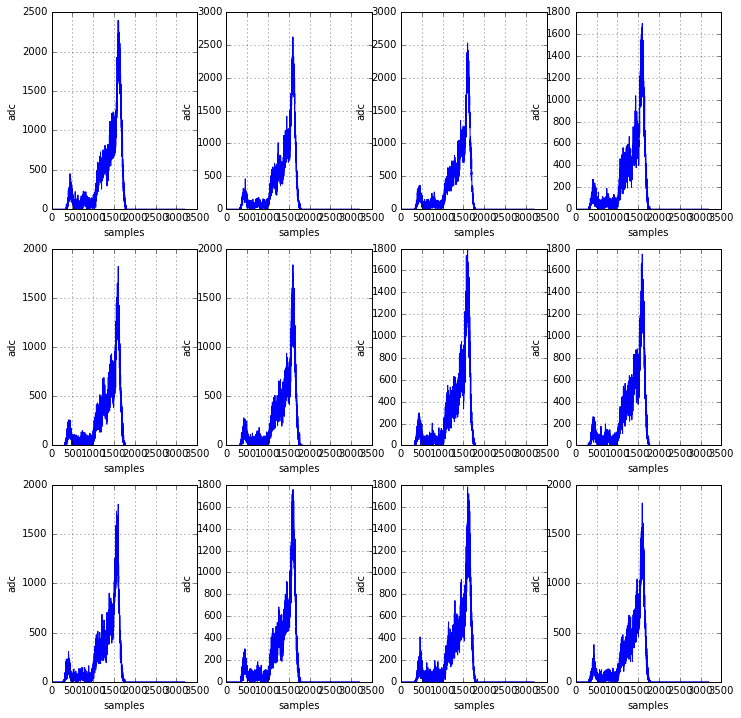

In [326]:
mpl.plot_waveforms(BLRX, maxlen=0, zoom=True, window_size=1600)

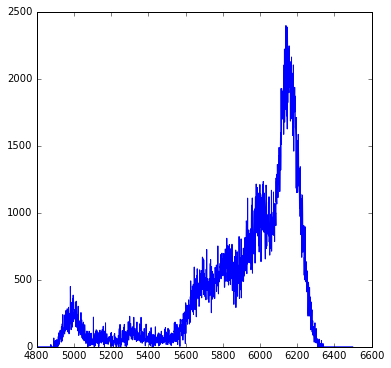

In [331]:
plt.figure(figsize=(6, 6))
xmin=4800
xmax=6500
plt.plot(range(xmin,xmax),BLRX[0][xmin:xmax])

event = 0
baseline = 2500.00551637 noise (LSB_rms) = 0.890759777064
trigger line = 4.45379888532 LSB
Input Energy = 629974.086925
Reconstructed Energy = 630462.295524
Error in Energy Computation (%) = 0.0774966159875


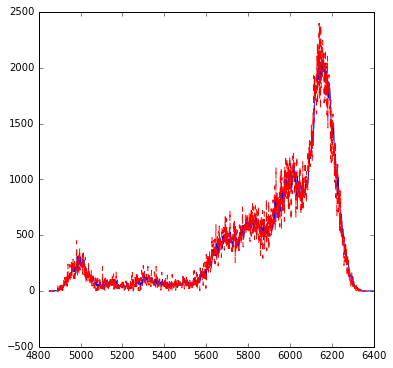

In [332]:
ER = blr_stats(e1250.root.pmtrd, event_list=range(1), xmin=4850, xmax=6400, pmtid=0, plot=True)

event = 4
baseline = 2499.9923656 noise (LSB_rms) = 0.835361238836
trigger line = 4.17680619418 LSB
Input Energy = 198315.424278
Reconstructed Energy = 198348.037015
Error in Energy Computation (%) = 0.0164448817885


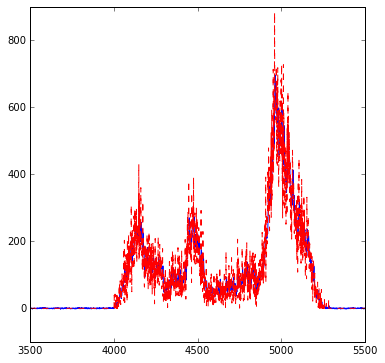

In [346]:
ER = blr_stats(e1250.root.pmtrd, event_list=range(4,5), xmin=3500, xmax=5500, pmtid=0, plot=True)

### Algorithm seems to work very well, but for a proper comparison one needs to select S2's

In [348]:
RWF, BLRX = fee_response(e2500.root.pmtrd, event=0) 

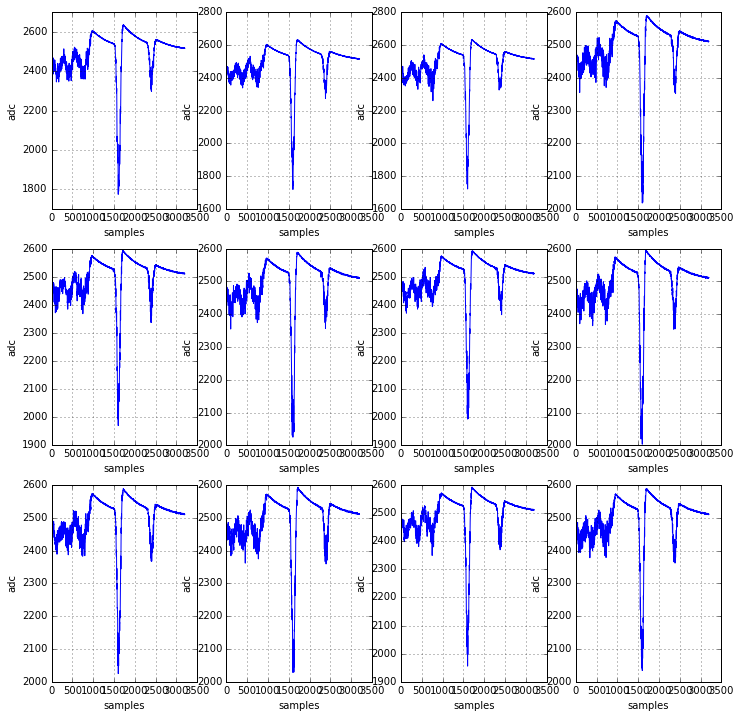

In [349]:
mpl.plot_waveforms(RWF, maxlen=0, zoom=True, window_size=1600)

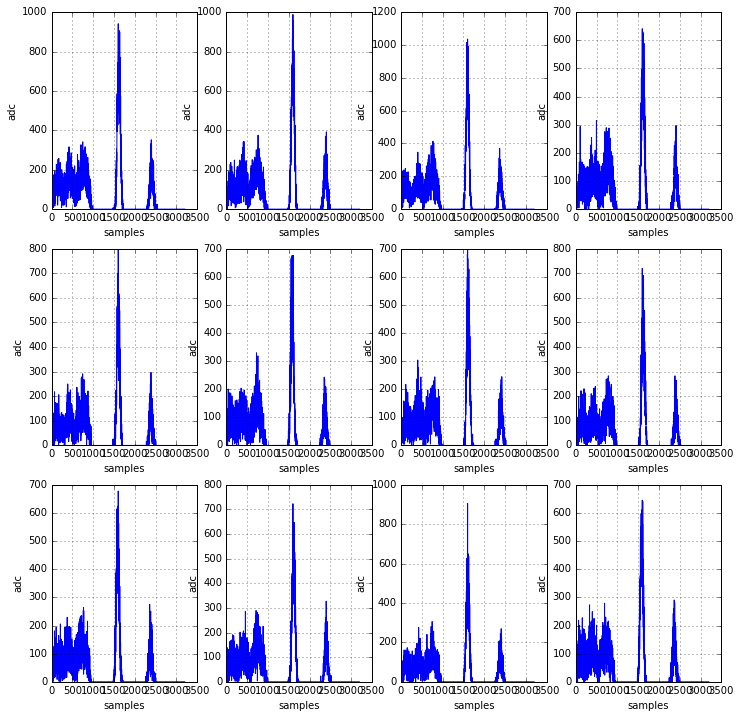

In [350]:
mpl.plot_waveforms(BLRX, maxlen=0, zoom=True, window_size=1600)

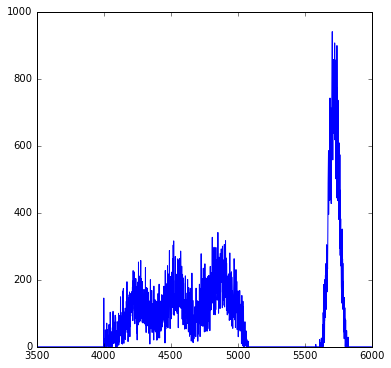

In [353]:
plt.figure(figsize=(6, 6))
xmin=3500
xmax=6000
plt.plot(range(xmin,xmax),BLRX[0][xmin:xmax])

event = 0
baseline = 2500.03221268 noise (LSB_rms) = 0.910382871553
trigger line = 4.55191435776 LSB
Input Energy = 193903.8469
Reconstructed Energy = 194149.629521
Error in Energy Computation (%) = 0.126754896826


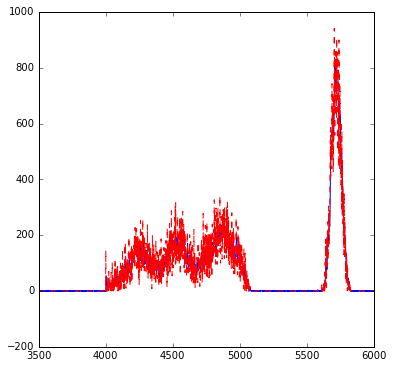

In [354]:
ER = blr_stats(e2500.root.pmtrd, event_list=range(1), xmin=3500, xmax=6000, pmtid=0, plot=True)

#### Deconvolution seems to work very well!

## Find s1 and s2

In [210]:
from scipy import signal as SGN

In [311]:
def find_s12(signal_i, blevt=1000, thr1=3, thr2=1.5):

    """
    1) compute baseline using the first blevt events
    2) compute noise rms using first blevt events
    3) detect start of signal if signal > sigma_start*rms_noise
    4) detect end of signal if signal < sigma_end*rms_noise
    5) label signal as s1 if len(signal) < 1mus (400 bins of 25 ns)
    6) label signal as s2 otherwise.
    """
    
    nm = blevt
    len_signal_i = len(signal_i)
    mau = np.zeros(nm, dtype=np.double)
    pulse_on = np.zeros(len_signal_i, dtype=np.int8)
    bmau = (1./nm)*np.ones(nm)

#   MAU averages the signal in the initial tranch
#    allows to compute the baseline of the signal

    mau = SGN.lfilter(bmau,1, signal_i[0:nm])
    baseline = mau[nm-1]
    noise_rms = np.std(signal_i[0:nm],ddof=1)
    
    p_on = 0
    trigger_on = baseline + thr1
    trigger_off = baseline + thr2
    S12L = []
    n = 0
    for k in range(nm,len_signal_i):
        pulse_on[k] = p_on
    
        if signal_i[k] > trigger_on:
            if p_on == 0: # pulse just started
                p_on = 1
                S12E = [signal_i[k] - baseline]
                S12T = [k * FE.t_sample]
                S12 = {}
                S12['e_adc'] =  S12E
                S12['t_ns'] = S12T
                S12L.append(S12)
            else:
                S12 = S12L[n]
                S12['e_adc'].append(signal_i[k] - baseline)
                S12['t_ns'].append(k * FE.t_sample)
        
        elif signal_i[k] > trigger_off and p_on == 1:
                S12 = S12L[n]
                S12['e_adc'].append(signal_i[k] - baseline)
                S12['t_ns'].append(k * FE.t_sample)
                
        elif signal_i[k] < trigger_off and p_on == 1:
                n+=1
                p_on = 0
            
    return  baseline, noise_rms, pulse_on, S12L


In [221]:
baseline, noise_rms, pulse_on, S12 = find_s12(signal_r)
mr = np.amax(signal_r)

baseline = -0.0657867632688 adc, noise_rms = 0.861903125011 adc


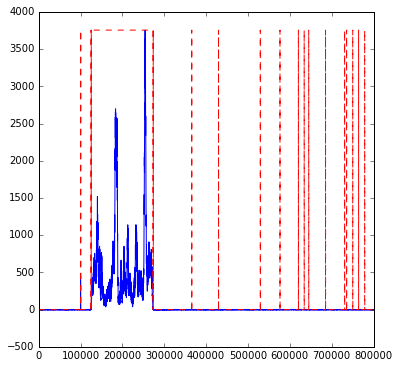

In [222]:
plt.figure(figsize=(6, 6))
plt.plot(np.arange(len(signal_r))*FE.t_sample, signal_r)
plt.plot(np.arange(len(signal_r))*FE.t_sample, pulse_on*mr, 'r--', linewidth=1)
print('baseline = {} adc, noise_rms = {} adc'.format(baseline, noise_rms))
plt.show()

In [324]:
baseline, noise_rms, pulse_on, S12L = find_s12(signal_r,thr1=5, thr2=3.0)
mr = np.amax(signal_r)

In [325]:
def plot_s12_search(signal_r, baseline, noise_rms, pulse_on):
    plt.figure(figsize=(6, 6))
    plt.plot(np.arange(len(signal_r))*FE.t_sample, signal_r)
    plt.plot(np.arange(len(signal_r))*FE.t_sample, pulse_on*mr, 'r--', linewidth=1)
    print('baseline = {} adc, noise_rms = {} adc'.format(baseline, noise_rms))
    plt.show()

baseline = -0.0657867632688 adc, noise_rms = 0.861903125011 adc


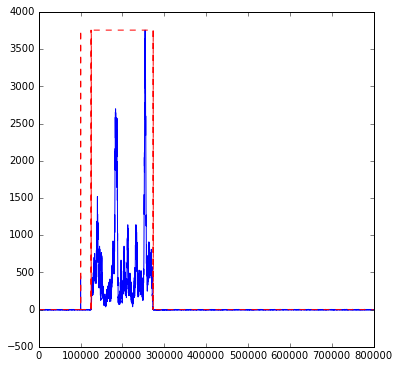

In [326]:
plot_s12_search(signal_r, baseline, noise_rms, pulse_on)

In [289]:
len(S12L)

4

In [256]:
def classify_S12(S12L):
    for s12 in S12L:
        s12e = np.array(s12['e_adc'])
        emax = np.amax(s12e)
        print('len of s12e = {} ns, max = {} adc '.format(len(s12e)*FE.t_sample, emax))
        

In [257]:
classify_S12(S12L)

len of s12e = 425.0 ns, max = 451.953460958 adc 
len of s12e = 250.0 ns, max = 20.1847911523 adc 
len of s12e = 147900.0 ns, max = 3756.53162552 adc 
len of s12e = 300.0 ns, max = 35.8858006248 adc 


In [386]:
def stats_S12(h5f, event_list, thr1=5, thr2=1.0, s12min=2, lenmax = 1000, pmt=0):
    s12L = []
    s12E = []
    s12EM = []
    s12N = []
    S1 = []
    S2 = []
    for event in event_list:
        signal_d, signal_daq, signal_r = fee_response(h5f, event=event, pmt=pmt)
        baseline, noise_rms, pulse_on, S12L = find_s12(signal_r,thr1=thr1, thr2=thr2)
        
        #print(len(S12L))
        if len(S12L) != s12min:
            continue
        
        s12N.append(len(S12L))
        
        for s12 in S12L:
            s12e = np.array(s12['e_adc'])
            emax = np.amax(s12e)
            s12L.append(len(s12e))
            s12EM.append(np.amax(s12e))
            s12E.append(np.sum(s12e))
            if len(s12e) > lenmax:
                S2.append(s12)
            else:
                S1.append(s12)
    return S1, S2, np.array(s12N), np.array(s12L), np.array(s12EM), np.array(s12E)

In [387]:
S1, S2, s12N, s12L, s12EM, s12E = stats_S12(e2500,range(100), thr1=5, thr2=3.0,s12min = 2)

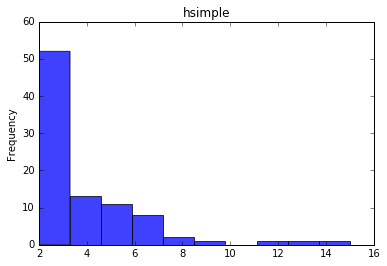

In [347]:
mpl.histo(s12N, nbins=10)

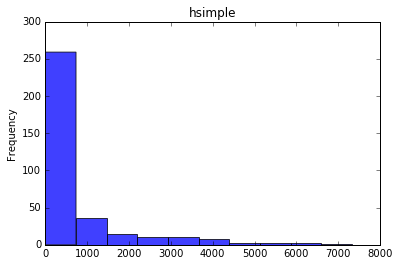

In [348]:
mpl.histo(s12L, nbins=10)

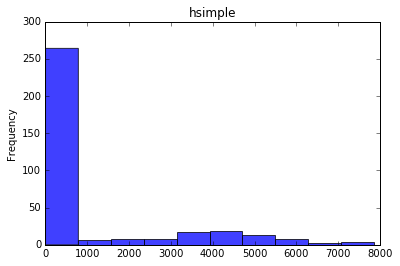

In [349]:
mpl.histo(s12EM, nbins=10)

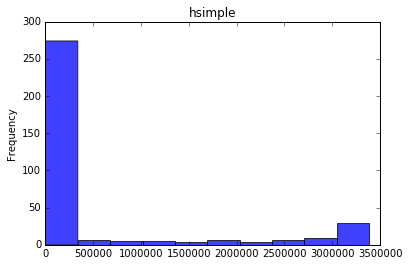

In [350]:
mpl.histo(s12E, nbins=10)

In [390]:
len(S1)

27

In [358]:
def stats_S1(S1L):
    s12L = []
    s12E = []
    s12EM = []
    for s12 in S1L:
        s12e = np.array(s12['e_adc'])
        emax = np.amax(s12e)
        s12L.append(len(s12e))
        s12EM.append(np.amax(s12e))
        s12E.append(np.sum(s12e))
        
    return np.array(s12L), np.array(s12EM), np.array(s12E)

In [388]:
s12L, s12EM, s12E = stats_S1(S1)

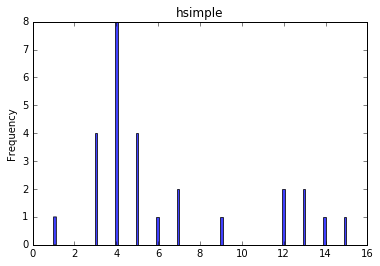

In [389]:
mpl.histo(s12L, nbins=100)

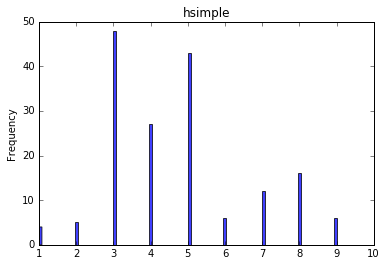

In [385]:
mpl.histo(s12L[np.where(s12L < 10)], nbins=100)

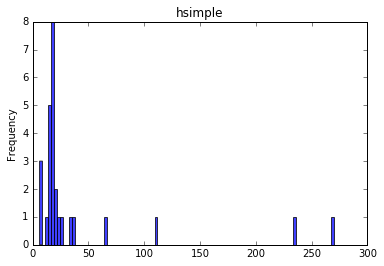

In [391]:
mpl.histo(s12EM, nbins=100)

In [ ]:
mpl.histo(s12EM, nbins=100) np.sum(pulse[np.where(pulse > thr)])

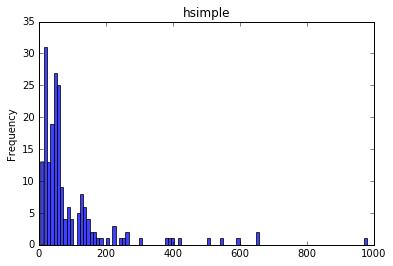

In [383]:
mpl.histo(s12E[np.where(s12E < 1000)], nbins=100)

In [392]:
s12L, s12EM, s12E = stats_S1(S1)

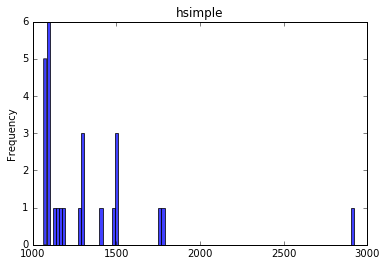

In [370]:
mpl.histo(s12L, nbins=100)

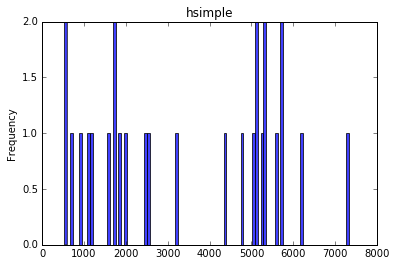

In [371]:
mpl.histo(s12EM, nbins=100)

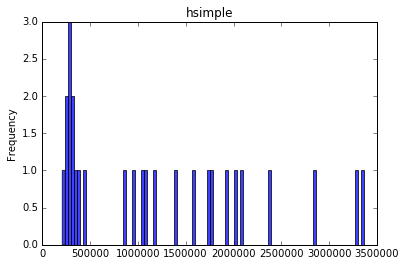

In [372]:
mpl.histo(s12E, nbins=100)

In [275]:
def select_S12(S12L):
    S1L =[]
    S2L =[]
    for s12 in S12L:
        if len(s12) == 2:
            S1L.append(s12[0])
            S2Lappend(s12[1])
    return S1L, S2L            

In [276]:
s1L, s2L= select_S12(S12L)

KeyError: 0

In [ ]:
def get_s1_s2(S

## Statistics

In [ ]:
def blr_energy_resolution(h5f, event_list, pmt=0):
    for event in event_list:
        signal_d, signal_daq, signal_r = fee_response(h5f, event=event, pmt=pmt)
        